In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import torch
import ot
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Arial')
matplotlib.rcParams['mathtext.fontset']='stix'
matplotlib.rcParams['font.size']=10
pd.set_option('display.max_rows', 1000)
root = '.'

2024-02-01 14:14:14.476043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_data(roots=['./alpha'], datanames=['db']):
    names=['Model', 'Case', 'P', 'Seed', 'RMSE', 'MAE', 'Wass', 'err1', 'err2']
    assert type(roots) is list
    data = []
    
    for root in roots:
        dirs = os.listdir(f"{root}")
        for dir in dirs:
            dataname, model, _, batch, lr, n_epoch, n_pairs, noise, _, alpha, _ = dir.split('_')
            if 'md' in dir:
                continue
            if dataname not in datanames:
                continue
            _data = pd.read_csv(f"{root}/{dir}/assets.txt", sep=",", header=None, names=names)
            _data['batch'] = batch
            _data['n_epochs'] = n_epoch
            _data['n_pairs'] = n_pairs
            _data['alpha'] = alpha
            _data['lr'] = lr
            data.append(_data)
    return pd.concat(data)

In [3]:
load_data(['./lr']);

#### Hparam study

In [52]:
def plot(dataset, figure_name='figure', x='labda', x_name='$\lambda$', ytick1=None, ytick2=None, ypad1=0.005, ypad2=0.005):
    
    dataset[x]=dataset[x].astype(str) # 这一步是为了把x转为字符串，防止间距不等。
    f = plt.figure(dpi=400, figsize=(8,3)) # 如果只画一条线，就用红色，高改为3->2.5
    f.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.2)
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    context = ['paper', 'notebook', 'talk', 'poster']
    palette = sns.color_palette('deep')
    palette = [palette[3], palette[0], palette[2]] + palette[4:]
    sns.set_theme(style=style[0], context=context[0], font='Arial', font_scale=1.6, palette=[palette[0], palette[3], palette[2]] + palette[4:])
    legend_location = 'upper left' # 这里可以根据图的实际情况调节。

    with PdfPages(f"./{figure_name}.pdf") as pdf:
        f.add_subplot(1,2,1)
        sns.lineplot(x=x, y='MAE', hue='P', data=dataset, style='P', errorbar=('ci', 90), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
        ax = plt.gca()
        ax.yaxis.set_major_locator(plt.MultipleLocator(ypad1)) # 小数点后3位数间隔。
        plt.legend(ncol=2, loc=legend_location)
        plt.xlabel(x_name)
        plt.ylabel('MAE')
        if ytick1:
            plt.yticks(ytick1)

        f.add_subplot(1,2,2)
        sns.lineplot(x=x, y='RMSE', hue='P', data=dataset, style='P', errorbar=('ci', 99.9), markers=['^', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette=palette)
        ax = plt.gca()
        ax.yaxis.set_major_locator(plt.MultipleLocator(ypad2))
        plt.legend(ncol=2, loc=legend_location)
        plt.tight_layout()
        plt.xlabel(x_name)
        plt.ylabel('RMSE')
        # plt.yscale('log')
        if ytick2:
            plt.yticks(ytick2)
        pdf.savefig(f, bbox_inches='tight', pad_inches=0.01)

/tmp/ipykernel_424575/727324534.py:14: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x=x, y='MAE', hue='P', data=dataset, style='P', errorbar=('ci', 90), markers=['s', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette="ch:start=.2,rot=-.3")
/tmp/ipykernel_424575/727324534.py:24: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.lineplot(x=x, y='RMSE', hue='P', data=dataset, style='P', errorbar=('ci', 99.9), markers=['^', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette=palette)
/tmp/ipykernel_424575/727324534.py:24: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x=x, y='RMSE', hue='P', data=dataset, style='P', errorbar=('ci', 99.9), markers=['^', 'o', "P", "*"], linewidth=3, markersize=8, markeredgecolor='k', palette=palette)


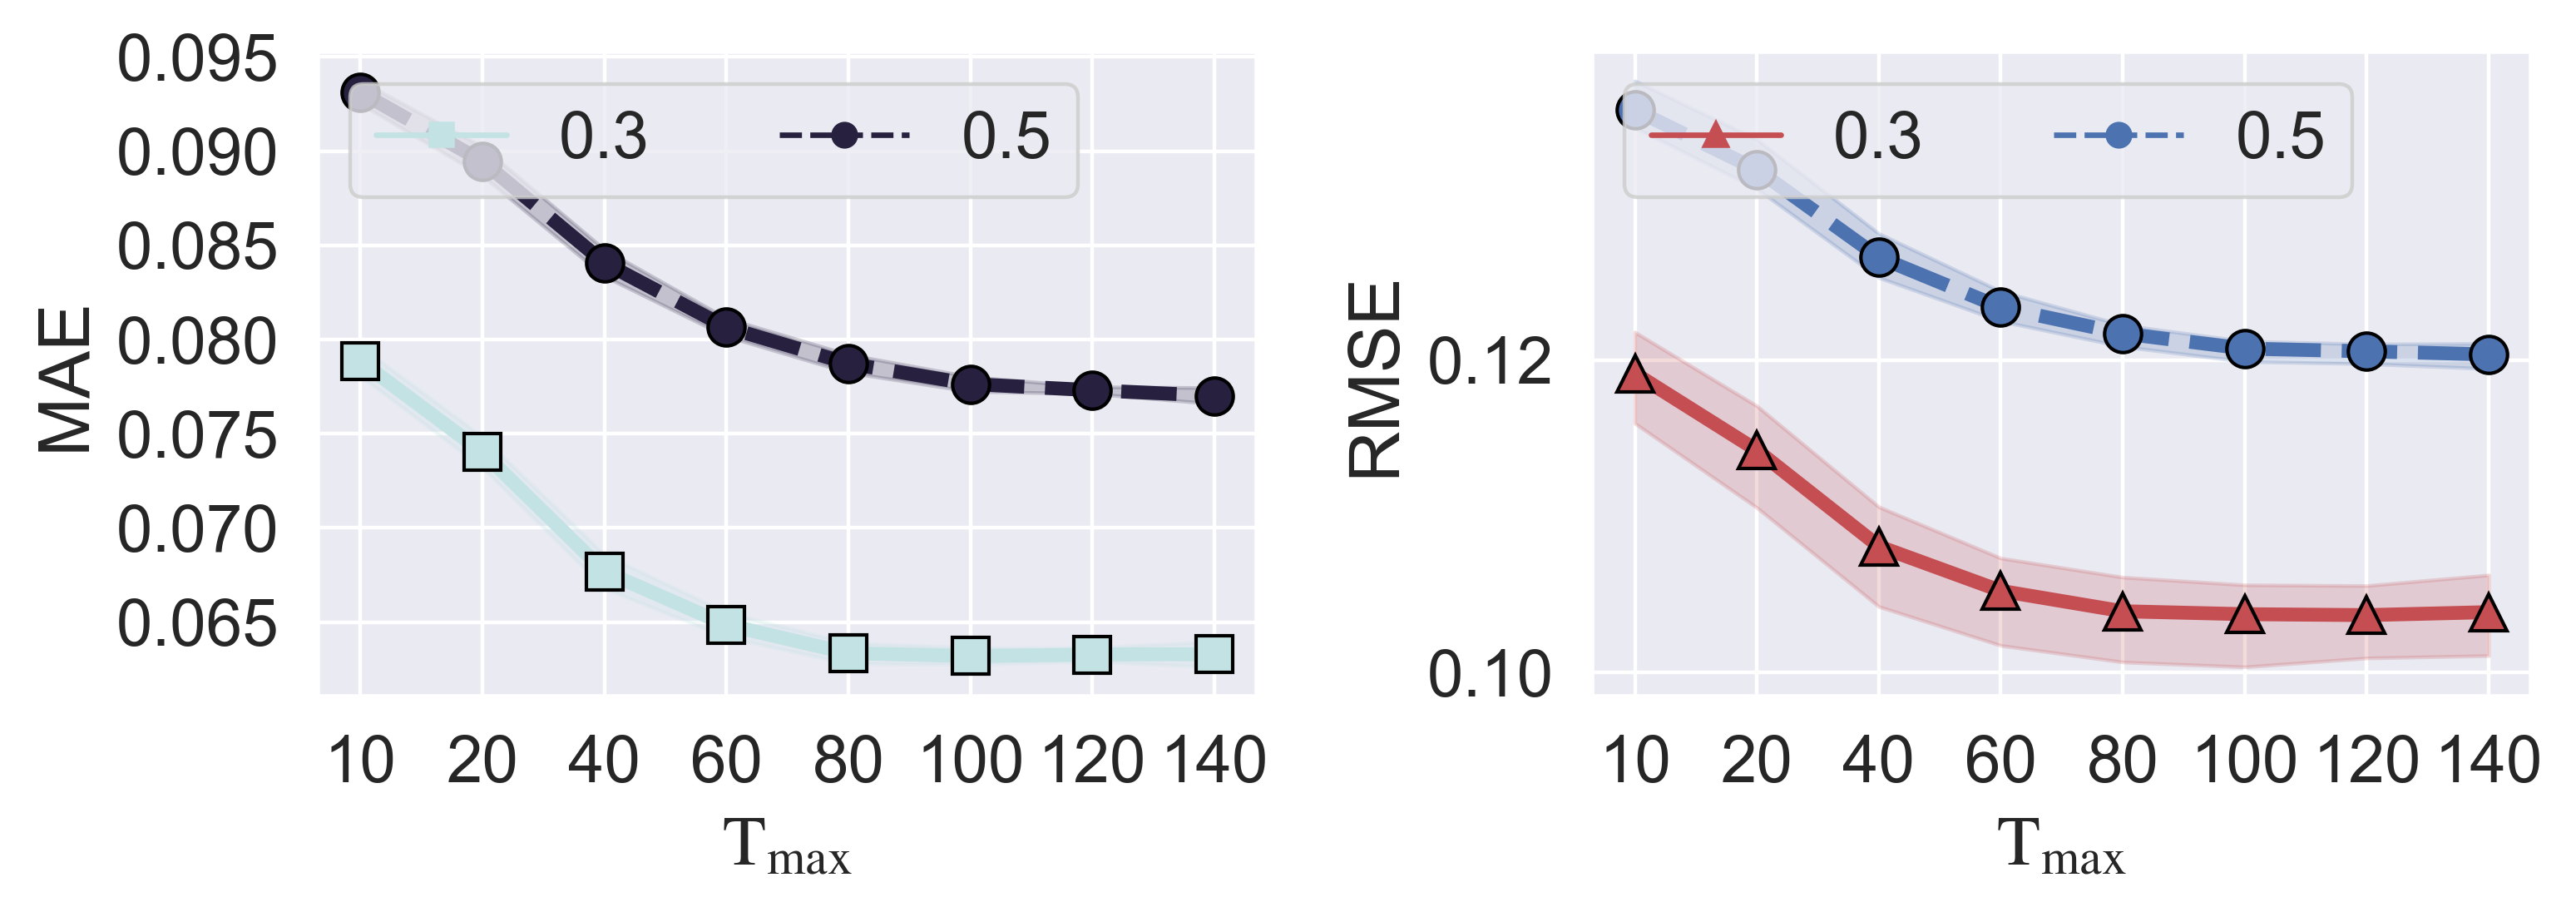

In [53]:
x_column = 'n_epochs'
data_batchsize = load_data(roots=[f'./{x_column}']).query("Case=='MCAR'").query("P==0.3 or P==0.5")
data_batchsize[x_column] = data_batchsize[x_column].astype(int)
data_batchsize = data_batchsize.sort_values(by=x_column).query("n_epochs!=160")
plot(data_batchsize, figure_name=f'figure_{x_column}', x=x_column, x_name='$\mathrm{T}_\mathrm{max}$', ytick1=None, ytick2=None, ypad2=0.02)

#### Ablation study

In [54]:
def load_data_ablate(roots=['./ablate'], datanames=['db']):
    names=['Model', 'Case', 'P', 'Seed', 'RMSE', 'MAE', 'Wass', 'err1', 'err2']
    assert type(roots) is list
    data = []
    
    for root in roots:
        dirs = os.listdir(f"{root}")
        for dir in dirs:
            dataname = dir.split('_')[0]
            if 'md' in dir:
                continue
            if dataname not in datanames:
                continue
            _data = pd.read_csv(f"{root}/{dir}/assets.txt", sep=",", header=None, names=names)
            _data['dir'] = dir
            data.append(_data)
    return pd.concat(data)

In [55]:
data_ablate = load_data_ablate()
def rename(row):
    if row.loc['Model'] == 'si':
        return "$\mathbb{W}$"
    else:
        if row.dir.split('_')[-2] == '1.0':
            return "$\mathbb{G}$"
        else:
            return "$\mathbb{S}$"
data_ablate['Model'] = data_ablate.apply(rename, axis=1)

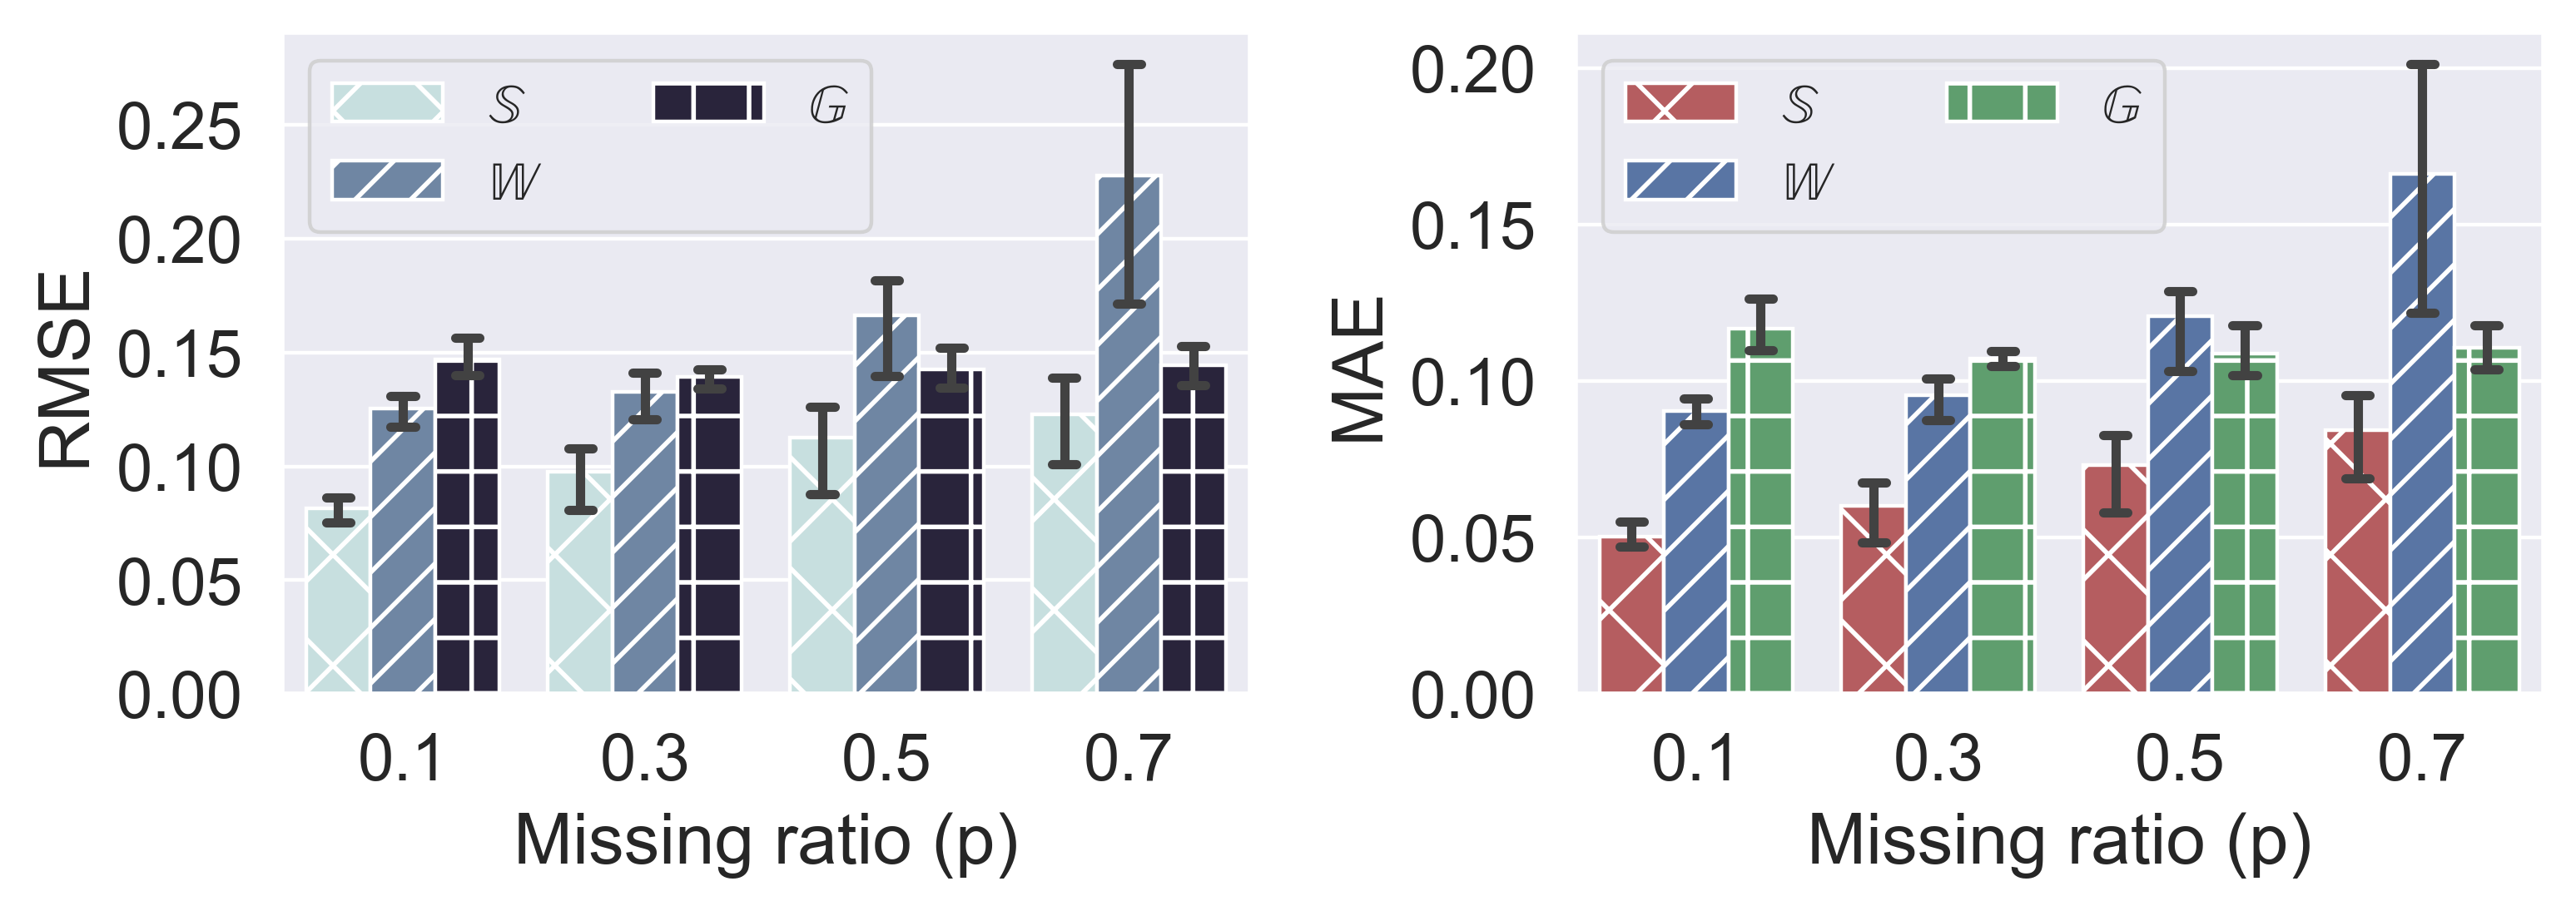

In [57]:
with PdfPages(f'figure_ablate.pdf') as pdf:
    # 以generalization to different backbone为例：横轴是backbone的名字、纵轴是指标、hue=[with FreDF, w/o FreDF]。对各个数据可以各画一个。
    # 对generalization to fft/poly：横轴是预测步长/数据集、纵轴是指标、hue=[Time, FFT-T，FFT-D，FFT-2D] / [Time, Leg., Fouri., Lag., Cheb.]。
    f = plt.figure(dpi=400, figsize=(8,3)) # 如果只画一条线，就用红色，高改为3->2.5
    f.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.2)
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    context = ['paper', 'notebook', 'talk', 'poster']
    palette = sns.color_palette('deep')
    palette = [palette[3], palette[0], palette[2]] + palette[4:]
    sns.set_theme(style=style[0], context=context[0], font='Arial', font_scale=1.6, palette=[palette[0], palette[3], palette[2]] + palette[4:])
    legend_location = 'upper left' # 这里可以根据图的实际情况调节。
    
    f.add_subplot(1,2,1)
    bar = sns.barplot(x='P', y='RMSE', hue='Model', data=data_ablate, palette="ch:start=.2,rot=-.3", errwidth=2, capsize=0.1, errorbar=('ci', 99.9))
    [bar.patches[i].set_hatch('x') for i in range(4)]; [bar.patches[i].set_hatch('//') for i in range(4,8)]; [bar.patches[i].set_hatch('+') for i in range(8,12)]
    ax = plt.gca()
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
    plt.legend(fontsize=12, ncols=2) # 这里的字号可以调小1-2号，如果字太多了的话。
    plt.xlabel('Missing ratio (p)')
    plt.ylabel('RMSE')
    # plt.yscale('log')

    f.add_subplot(1,2,2)
    bar = sns.barplot(x='P', y='MAE', hue='Model', data=data_ablate, palette=palette, errwidth=2, capsize=0.1, errorbar=('ci', 99.9))
    [bar.patches[i].set_hatch('x') for i in range(4)]; [bar.patches[i].set_hatch('//') for i in range(4,8)]; [bar.patches[i].set_hatch('+') for i in range(8,12)]

    ax = plt.gca()
#     ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    plt.legend(fontsize=12, ncols=2)
    plt.ylabel('MAE')
    # plt.yscale('log')
    plt.xlabel('Missing ratio (p)')
    # plt.ylim([7.5e-3,1e-2])
    plt.tight_layout()
    pdf.savefig(f, bbox_inches='tight', pad_inches=0.02)